<p align="center"><img width="50%" src="https://aimodelsharecontent.s3.amazonaws.com/aimodshare_banner.jpg" /></p>


---




<p align="center"><h1 align="center">Flower Image Classification with PyTorch</h1> <h3 align="center">(Prepare to deploy model and preprocessor to REST API/Web Dashboard in four easy steps...)</h3></p>
<p align="center"><img width="80%" src="https://aimodelsharecontent.s3.amazonaws.com/ModelandPreprocessorObjectPreparation.jpeg" /></p>


---



## **(1) Preprocessor Function & Setup**

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# https://drive.google.com/drive/folders/1jXmJ3LWozrHEo9elqJwtlllsCE0Rwzqx?usp=sharing # Image folder.
# https://drive.google.com/file/d/1LoJG9WAqB0F-EOgAAMBahJe7CzUk8PMP/view?usp=sharing # .csv file.

In [2]:
# Importing some packages...
from skimage.io import imread
from tqdm import tqdm

In [3]:
import pandas as pd

train = pd.read_csv('/content/gdrive/My Drive/pytorch/flower_photos/training_set/training.csv')

train.head()

,label,Id,image_type
0,tulips,420216121_3ee33723d7_m,.jpg
1,tulips,19425920580_cdc8f49aed_n,.jpg
2,tulips,8605564823_7a59d3d92a,.jpg
3,tulips,16303377824_6e9128b4bd,.jpg
4,tulips,2503489175_f0848d3e8e,.jpg


In [4]:
training_path = '/content/gdrive/My Drive/pytorch/flower_photos/training_set/'

In [5]:
train['label'] = train['label'].map({'tulips': 1, 'daisy': 2, 'dandelion': 3,
                                     'sunflowers': 4, 'roses': 5})

In [6]:
train = train.rename(columns={'Id':'id'})

### **Write a Preprocessor Function**

In [7]:
def preprocessor(data_path, labels_df):
        """
        This function preprocesses/reads in images, resizes them to a fixed shape and
        min-max transforms them before converting feature values to float32 numeric values
        required by ONNX. (NB Use GPU for your models.)
        
        params:
            data_path
                list of unprocessed images
            labels_df
                dataframe storing the image labels
                      
        returns:
            preprocessor
                preprocessed image data
                  
        """
           
        import cv2

        preprocessed_img = []
        for img_name in tqdm(labels_df['id']):
            image_path = data_path + str(img_name) + '.jpg' # Define image path.
            img = cv2.imread(image_path) # Read in the image.
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, dsize=(28, 28)) # Smaller works better.
            img = img / 255.0 # Normalization.
            img = img.astype('float32') # float32 for ONNX.
            preprocessed_img.append(img) # Append images to a list.
        return preprocessed_img

In [24]:
import numpy as np

train_x = np.array(preprocessor(training_path, train)) # Convert to a numpy array.
train_y = train['label'].values # Define the target.
train_x.shape

100%|██████████| 2935/2935 [00:14<00:00, 201.43it/s]


(2935, 28, 28, 3)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f315afbdfd0>,
 <matplotlib.image.AxesImage at 0x7f315af78240>)

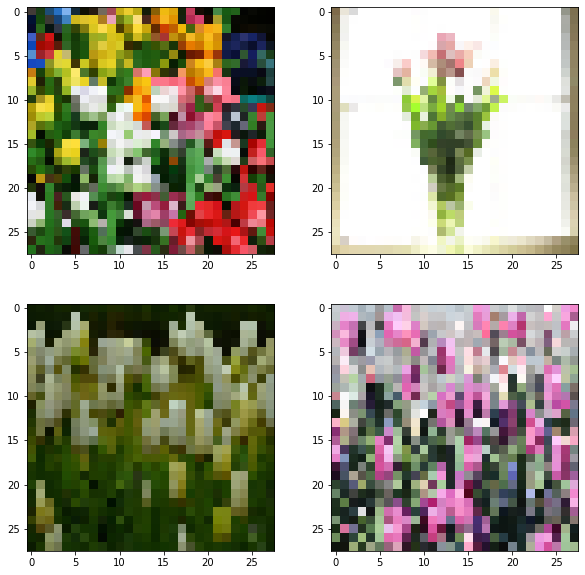

In [25]:
# Visualize some images...
import matplotlib.pyplot as plt
%matplotlib inline

i = 0
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(train_x[i])
plt.subplot(222), plt.imshow(train_x[i+25])
plt.subplot(223), plt.imshow(train_x[i+50])
plt.subplot(224), plt.imshow(train_x[i+75])

In [26]:
# `train_test_split()`...
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.1)
(train_x.shape, train_y.shape), (test_x.shape, test_y.shape)

(((2641, 28, 28, 3), (2641,)), ((294, 28, 28, 3), (294,)))

In [27]:
train_y # Sanity check. Looks right! NB tulips = 1, daisy = 2, dandelion = 3, sunflowers = 4, roses = 5.

array([1, 5, 5, ..., 3, 1, 2])

In [13]:
# PyTorch packages...
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [28]:
# Convert training images to torch format...
train_x = np.transpose(train_x, (0, 3, 1, 2))
train_x  = torch.from_numpy(train_x)

# Convert the target to torch format...
train_y = train_y.astype(int);
train_y = torch.from_numpy(train_y)

train_x.shape, train_y.shape # Check shape.

(torch.Size([2641, 3, 28, 28]), torch.Size([2641]))

In [29]:
# Same conversions for the test-set...
test_x = np.transpose(test_x, (0, 3, 1, 2))
test_x  = torch.from_numpy(test_x)

test_y = test_y.astype(int);
test_y = torch.from_numpy(test_y)

test_x.shape, test_y.shape # Check shape.

(torch.Size([294, 3, 28, 28]), torch.Size([294]))

## **(2) Train Model Using `torch`**

In [30]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Define a 2D convolution layer...
            Conv2d(3, 4, kernel_size=3, stride=1, padding=1), # Read [here](https://stackoverflow.com/questions/56675943/meaning-of-parameters-in-torch-nn-conv2d) for more info.
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Another 2D convolution layer...
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(4 * 7 * 7, 10)
        )

    # Define the forward pass...    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [31]:
model = Net() # Define model.
optimizer = Adam(model.parameters(), lr=0.07) # Define optimizer.
criterion = CrossEntropyLoss() # Define loss function.
# Check if GPU is available...
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


In [32]:
def train(epoch):
    model.train()
    tr_loss = 0
    x_train, y_train = Variable(train_x), Variable(train_y) # Retrieve the training-set.
    x_test, y_test = Variable(test_x), Variable(test_y) # Retrieve the test-set.
    # Convert the data to GPU format...
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_test = x_test.cuda()
        y_test = y_test.cuda()

    optimizer.zero_grad() # Clear the Gradients of the model params.
    
    # Prediction for training- and test-sets...
    output_train = model(x_train)
    output_test = model(x_test)

    # Compute the training and test loss...
    loss_train = criterion(output_train, y_train)
    loss_test = criterion(output_test, y_test)
    train_losses.append(loss_train)
    test_losses.append(loss_test)

    # Compute the updated weights of all the model params...
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # Print the test loss...
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_test)

In [33]:
n_epochs = 75 # Define # of epochs.
train_losses = [] # Empty list to store training losses.
test_losses = [] # Ditto for test losses.

# Train the model...
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : tensor(2.4768, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  3 	 loss : tensor(4.6536, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  5 	 loss : tensor(1.9951, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  7 	 loss : tensor(1.6438, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  9 	 loss : tensor(1.5271, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  11 	 loss : tensor(1.5482, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  13 	 loss : tensor(1.6050, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  15 	 loss : tensor(1.6071, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  17 	 loss : tensor(1.5667, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  19 	 loss : tensor(1.5607, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  21 	 loss : tensor(1.5520, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  23 	 loss : tensor(1.5165, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  25 	 loss : tensor(1.4781, device='c

In [34]:
# Prediction for training-set...
from sklearn.metrics import accuracy_score

with torch.no_grad():
    output = model(train_x.cuda())
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

accuracy_score(train_y, predictions) # Accuracy on training-set.

0.5028398333964408

## **(3) Save Preprocessor**

In [ ]:
# ! pip3 install aimodelshare

In [35]:
def export_preprocessor(preprocessor_function, filepath):
    import dill
    with open(filepath, "wb") as f:
        dill.dump(preprocessor_function, f)

# import aimodelshare as ai # Once we can deploy this, we use it in lieu of the below.
# ai.export_preprocessor(preprocessor, "preprocessor.pkl")

export_preprocessor(preprocessor, "preprocessor.pkl")

## **(4) Save to ONNX**

In [36]:
model.eval() # Turn the model to inference mode. (Required since operators like dropout or batchnorm behave differently in inference and training mode.)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)

In [37]:
output = model(train_x.cuda())

# Export the model...
torch.onnx.export(model,                                        # Your model.
                  train_x.cuda(),                               # Model input (or a tuple for multiple inputs).
                  "my_model.onnx",                              # Save as.
                  export_params=True,                           # Store the trained parameter weights inside the model file.
                  opset_version=10,                             # The ONNX version to export the model to.
                  do_constant_folding=True,                     # Whether to execute constant folding for optimization.
                  input_names = ['input'],                      # The model's input names.
                  output_names = ['output']) #,                 # The model's output names.
#                 dynamic_axes={'input' : {0 : 'batch_size'},   # Variable lenght axes.
#                               'output' : {0 : 'batch_size'}})

In [ ]:
! pip3 install onnx

In [39]:
import onnx

onnx_model = onnx.load("/content/my_model.onnx")
onnx.checker.check_model(onnx_model)

In [40]:
onnx.helper.printable_graph(onnx_model.graph)

'graph torch-jit-export (\n  %input[FLOAT, 2641x3x28x28]\n) initializers (\n  %34[INT64, 1]\n  %cnn_layers.0.bias[FLOAT, 4]\n  %cnn_layers.0.weight[FLOAT, 4x3x3x3]\n  %cnn_layers.1.bias[FLOAT, 4]\n  %cnn_layers.1.running_mean[FLOAT, 4]\n  %cnn_layers.1.running_var[FLOAT, 4]\n  %cnn_layers.1.weight[FLOAT, 4]\n  %cnn_layers.4.bias[FLOAT, 4]\n  %cnn_layers.4.weight[FLOAT, 4x4x3x3]\n  %cnn_layers.5.bias[FLOAT, 4]\n  %cnn_layers.5.running_mean[FLOAT, 4]\n  %cnn_layers.5.running_var[FLOAT, 4]\n  %cnn_layers.5.weight[FLOAT, 4]\n  %linear_layers.0.bias[FLOAT, 10]\n  %linear_layers.0.weight[FLOAT, 10x196]\n) {\n  %17 = Conv[dilations = [1, 1], group = 1, kernel_shape = [3, 3], pads = [1, 1, 1, 1], strides = [1, 1]](%input, %cnn_layers.0.weight, %cnn_layers.0.bias)\n  %18 = BatchNormalization[epsilon = 9.99999974737875e-06, momentum = 0.899999976158142](%17, %cnn_layers.1.weight, %cnn_layers.1.bias, %cnn_layers.1.running_mean, %cnn_layers.1.running_var)\n  %19 = Relu(%18)\n  %20 = MaxPool[ceil_m

In [ ]:
! pip3 install onnxruntime

In [42]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("my_model.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(train_x.cuda())}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(output), ort_outs[0], rtol=1e-03, atol=1e-05) # `assert_allclose` raises an AssertionError if two objects are not equal up to desired tolerance.

print("Exported model has been tested with ONNX Runtime, and the result looks good!")

Exported model has been tested with ONNX Runtime, and the result looks good!
